In [1]:
# Importing packages
import pandas as pd # Data structure and analysis package
import numpy as np # Computing package
import matplotlib.pyplot as plt # Plots
import math
import scipy as sp
from scipy import linalg
from scipy import optimize
import sympy as sm
from sympy import Max, Symbol, oo, Eq, solve
import nashpy as nash

In our project we consider the collusion game known from industrial organization/game theory courses. The firms compete over quantities i.e. ála Cournot.$^1$ We start by finding the profit in the Cournot case. After, we find each firms collusion profits and lastly we look at the optimal deviation from collusion and the profits that follows. In our model demand is charaterized by the inverse demand function: 
$$P=max\{a - b \cdot Q ,0\} $$
Firms are assumed to have constant marginal cost and the total cost for each firm is as follows:
$$TC = c \cdot q_i$$
We assume that $a-c>0$ such that the firm produces a positive quantity. Before finding the Cournot profit, we define our variables.

1: Alternatively, one could think of the competition as being over prices with capacity constraints which yield the Cornout output.  

In [3]:
Q = sm.symbols('Q')
q1 = sm.symbols('q_1')
q1s = sm.symbols('q_1*')
q2 = sm.symbols('q_2')
q2s = sm.symbols('q_2*')
P = sm.symbols('P')
a = sm.symbols('a')
c = sm.symbols('c')
pi1 = sm.symbols('pi_1')
pi2 = sm.symbols('pi_2')
TC1 = sm.symbols('TC_1')
TC2 = sm.symbols('TC_2')
delta = sm.symbols('delta')

We define our variables 

In [4]:
Q = q1 + q2
P = a - q1 - q2
TC1 = c * q1
TC2 = c * q2
pi1 = P * q1 - TC1
pi2 = P * q2 - TC2

We set $a$ and $b$ equal to some values. 

In [6]:
a = 100
c = 30
b = 1

We set up our profit maximization problem 
$$\underset{q_1}{max} \quad \pi = (a-b\cdot (q_1+q_2)) \cdot q_1 -c \cdot q_1 $$
and draw 1000 exogenous quantities for firm 2 for which we will find the best response for firm 1.  

In [7]:
N = 999
q2_vec = np.linspace(0,99,N) 
def pi11(q1):
    return (a-b*(q1+q2))*q1 -c * q1

We optimize firm 1's profit to the exogenous drawn quantity of firm 2 hence, finding the best response for firm 1 for a given quantity of firm 2. Below we apply the numerical optimizer BFGS. 

In [8]:
q2_try = []
q1_BR = []
pi1_BR = []

for i in q2_vec:
    q2 = i
    q1_guess = 60      
    objective_function = lambda q1: -pi11(q1)
    res = optimize.minimize(objective_function, q1_guess, method='BFGS')
    q2_try.append(i)
    q1_BR.append(res.x[0])
    pi1_BR.append(-res.fun)
res

      fun: -210.25000000000003
 hess_inv: array([[0.50000006]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 3
     njev: 6
   status: 0
  success: True
        x: array([-14.49999991])

Negative quantities do not make sense and therefore we set these to zero. Further, the firms will rather choose to produce no products and get a profit of zero than getting a negative profit thus, we set these to zero. Note that we do not change the negative profits for firm 2 as these are exogenous drawn and not a best response.

In [9]:
for i in range(N):
    if q1_BR[i]<=0 or pi1_BR[i]<=0:
        q1_BR[i]=0
        pi1_BR[i]=0
    else:
        pass

We gather out dataset in a DataFrame, as it is a rather small amout of data we are working with and hence are not constraint by time or storage.

In [17]:
df=pd.DataFrame(q2_try)
df.columns=['q2_exo']
df['q1_BR'] = q1_BR
df['pi1'] = pi1_BR 

df['P'] = a - df['q1_BR'] - df['q2_exo']
df['pi2'] = np.transpose(df['P'] * df['q2_exo']) - c * df['q2_exo']

df = df.round(1)
df.head(5)

,q2_exo,q1_BR,pi1,P,pi2
0,0.0,35.0,1225.0,65.0,0.0
1,0.1,35.0,1221.5,65.0,3.5
2,0.2,34.9,1218.1,64.9,6.9
3,0.3,34.9,1214.6,64.9,10.4
4,0.4,34.8,1211.2,64.8,13.8


Due to symmetry between the two firms we do not compute the best response for firm 2, but simply assume it to be equal to the best response of firm 1.

In [18]:
q1_exo=df['q2_exo'].copy()
q2_BR=df['q1_BR'].copy()

We plot the two best responses against each other. The intersection between the curves is the Nash equilibrium of Cournot game.

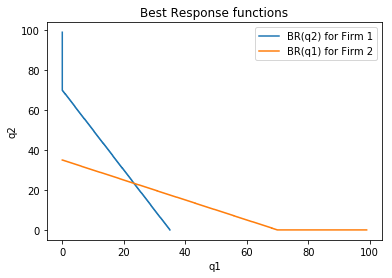

In [21]:
plt.plot(q2_BR[0:999], q1_exo[0:999], label='BR(q2) for Firm 1')
plt.plot(df['q2_exo'][0:999],df['q1_BR'][0:999], label='BR(q1) for Firm 2')
plt.xlabel('q1')
plt.ylabel('q2')
plt.title('Best Response functions')
plt.legend()
plt.show()

We will now find the intersection i.e. the Nash equilibrium. While we are at it, we also compute the profits that follow.

In [22]:
for i in range(N):
    if df['q2_exo'][i] == df['q1_BR'][i] and df['q1_BR'][i] > 0:
        pi_cournot = df['pi1'][i] 
        q_cournot = df['q1_BR'][i]
    else:
        pass

print(f'Profit cournot = {pi_cournot}')
print(f'Quantity cournot = {q_cournot}')

Profit cournot = 545.0
Quantity cournot = 23.3


## Collusion 

Instead of competing the firms can form a cartel and split the monopoly profit. In other words, the firms face the following maximization problem: 
$$\underset{Q}{max} \quad \pi = (a-Q) \cdot Q -c \cdot Q $$

In [23]:
def pi12(Q):
    return (a-Q)*Q - c * Q

Applying the same approch as before, we optimize the collusion problem:

In [33]:
objective_function = lambda Q: -pi12(Q)
res_col = optimize.minimize(objective_function, 20, method='BFGS')
Q_col=round(res_col.x[0],1)
pi_joint_col=-round(res_col.fun,1)

print(f'Total collusion quantity = {Q_col}')
print(f'Total collusion profit = {pi_joint_col}')

Total collusion quantity = 35.0
Total collusion profit = 1225.0


We thus found the total collusion quantity and profit from the optimization.
In the collusion equilibrium, the firms would share this quantity and profit equally due to symmetry. 
Hence we find the individual quantities and profits:

In [30]:
q_indi_col = round(Q_col * 0.5, 1)
pi_indi_col = round(pi_joint_col * 0.5,1)

print(f'Individual collusion quantity = {q_indi_col}')
print(f'Individual collusion profit = {pi_indi_col}')

Individual collusion quantity = 17.5
Individual collusion profit = 612.5


## Optimal deviation

If the firms decide to collude, one firm can cheat on the other and choose to deviate away from the colluding equilibrium. Instead of producing the agreed quantity, the deviating firm will choose to produce their best response quantity. Recall that we already know the best response function. 

In [34]:
pi_dev = round(float(df.loc[df['q2_exo']==q_indi_col, 'pi1']),1)
pi_no_col = round(float(df.loc[df['q2_exo']==q_indi_col, 'pi2']),1)

print(f'Optimal deviation profit = {pi_dev}')
print(f'The firm who gets cheated on profit = {pi_no_col}')

Optimal deviation profit = 690.1
The firm who gets cheated on profit = 458.7


## Static game between the firms

We have now calculated payoffs from all possible scenarios. As the firms simultaneously choose to play play either $Collusion$ or $Cournot$, we are able to write up a bimatrix for the cartel stability game.

In [35]:
Payoff_M = [[(pi_indi_col,pi_indi_col),(pi_no_col,pi_dev)],[(pi_dev,pi_no_col),(pi_cournot,pi_cournot)]]
Payoff_M = pd.DataFrame(Payoff_M, index = ['Collusion', 'Cournot'], columns = ['Collusion','Cournot'])
Payoff_M

,Collusion,Cournot
Collusion,"(612.5, 612.5)","(458.7, 690.1)"
Cournot,"(690.1, 458.7)","(545.0, 545.0)"


We solve for the subgame perfect Nash equilibrum.

We solve our bimatrix. We do this by using the package *nashpy* (if you have not already installed the package, it is done by typing *pip install nashpy* in your Anacondat Prompt or terminal + enter).  

In [45]:
p1_Payoff = np.array([[pi_indi_col,pi_no_col],[pi_dev,pi_cournot]])
p2_Payoff = np.array([[pi_indi_col,pi_dev],[pi_no_col,pi_cournot]])
rps = nash.Game(p1_Payoff, p2_Payoff)
eqs = rps.support_enumeration()
NE = list(eqs)

print(f'With probability {NE[0][0][0]} player 1 will play Collusion') 
print(f'With probability {NE[0][0][1]} player 1 will play Cournot')
print(f'With probability {NE[0][1][0]} player 2 will play Collusion')
print(f'With probability {NE[0][1][1]} player 2 will play Cournot')

With probability 0.0 player 1 will play Collusion
With probability 1.0 player 1 will play Cournot
With probability 0.0 player 2 will play Collusion
With probability 1.0 player 2 will play Cournot


We get the $SPNE = \{Cournot, Cournot\}$. In other words, the cartel stability game is a prisoners dilemma and the players end up in the pareto dominated scenario. 

## Infinetely repeated game

In most real world apliccations cartels do not just meet once, but instead multiple times where the firms in each period decide to either collude or compete. Then each period can be thought of as a new prisoners dilemma. If time is assumed to be infinite, we have infinitely many periods and the game is repeated infinitely many times (G($\infty$)).$^1$ If this is the case let us consider the grim trigger strategy which is defined as:

$s_{1,2}$: *In the first period play "Cartel". In every other period play* "Cartel" *if* "Cartel" *is played by 
the other firm in all previous periods. If* "Cartel" *is not played in every previous period play* "No Cartel".

We note that playing "No Cartel" is a Nash equilibrium and therefore a credible threat. Furthermore, we see that both firms can get a higher pay-off from deviating in the current period. However, the deviating firm will then get punished in all future periods. Therefore, there must exist a value of how much the firms have to value future profit compared to profit gained today in order not to deviate. Let us call this discounting value $\delta$. $\delta$ is found by solving the inequation below. 

$$\sum^{\infty}_{i=0} \delta^t \cdot \pi^{Col} \geq \pi^{dev} + \sum^{\infty}_{i=1} \delta^t \cdot \pi^{Cour} \Leftrightarrow$$
$$\frac{1}{1-\delta} \cdot \pi^{Col} \geq \pi^{dev} + \frac{\delta}{1-\delta} \cdot \pi^{Cour} $$

1: A more realistic and intuitive way to think of the infinite game is a game that is being played over and over, but might not be infinite. However, it is played so many times that the last times it is being played do not matter for the outcome in the current period. In that way the game might not be objectively infinite, but it is infinite in the minds of the players. Alternatively, the players do not know whether this is the last time the game is being played. They play the game believing that it is not the last round, while it actually could be the last round, but they behave as they will meet again.

In [60]:
d = sm.symbols('d')
delta = solve(Eq(1/(1-d) * pi_indi_col, pi_dev + d/(1-d) * pi_cournot),d)
print(f'delta = {round(delta[0],2)}')
print(f'The firms will not deviate as long as delta is larger than or equal {round(delta[0],2)}')

delta = 0.53
The firms will not deviate as long as delta is larger than or equal 0.53


Delta can be interpreted as how much the firms value profits gained tomorrow compared to those gained today and in that sense, the firms have to value profits gained tommorow $\delta$ times as much as profits gained today in order to sustain collusion.

We will now solve the whole game in a single function such that it is easier to solve the game with different values og $a$, $b$ and $c$

In [65]:
%reset
# Importing packages
import pandas as pd # Data structure and analysis package
import numpy as np # Computing package
import matplotlib.pyplot as plt # Plots
import math
import scipy as sp
from scipy import linalg
from scipy import optimize
import sympy as sm
from sympy import Max, Symbol, oo, Eq, solve
import nashpy as nash
#Now we make one function which solves the whole game
def combined_function(a,c,b): 
        N = 999
        q2_vec = np.linspace(0,99,N) 
        #Cournot. We start by profit maximization
        def pi11(q1):
            return (a- b* q1-b * q2)*q1 -c * q1
        q2_try = []
        q1_BR = []
        pi1_BR = []
        for i in q2_vec:
            q2 = i
            q1_guess = 60      
            objective_function = lambda q1: -pi11(q1)
            res = optimize.minimize(objective_function, q1_guess, method='BFGS')
            q2_try.append(i)
            q1_BR.append(res.x[0])
            pi1_BR.append(-res.fun)
  
        q1_BR = np.transpose(q1_BR)
        pi1_BR = np.transpose(pi1_BR)
        df=pd.DataFrame(q2_try)
        df.columns=['q2_exo']
        df['q1_BR'] = q1_BR
        df['pi1'] = pi1_BR 

        df['P'] = a - df['q1_BR'] - df['q2_exo']
        df['pi2'] = np.transpose(df['P'] * df['q2_exo']) - c * df['q2_exo']

        df = df.round(1)

        for i in range(N):
            if df['q2_exo'][i] == df['q1_BR'][i] and df['q1_BR'][i] > 0:
                pi_cournot = df['pi1'][i] 
                q_cournot = df['q1_BR'][i]
            else:
                pass
    
#Collusion
        def pi12(Q):
            return (a-b *Q)*Q - c * Q
        objective_function = lambda Q: -pi12(Q)
        res_col = optimize.minimize(objective_function, 20, method='BFGS')
        Q_col=res_col.x[0]
        pi_joint_col=-round(res_col.fun,1)
        pi_indi_col = round(pi_joint_col * 0.5,1)
        q_indi_col = round(Q_col * 0.5, 1)
#Optimal deviation
        pi_dev = round(float(df.loc[df['q2_exo']==q_indi_col, 'pi1']),1)
        pi_no_col = round(float(df.loc[df['q2_exo']==q_indi_col, 'pi2']),1)
#infinitely repeated game
        d = Symbol('d')
        delta = solve(Eq(1/(1-d) * pi_indi_col, pi_dev + d/(1-d) * pi_cournot),d)
        print(f'a/c = {a/c}, delta  = {round(delta[0],2)}, profit cournot = {pi_cournot}, profit collusion = {pi_indi_col}, profit deviation = {pi_dev}, profit cheated on = {pi_no_col}')


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [66]:
outcome = (combined_function(55,50,1), 
           combined_function(200,100,1), 
           combined_function(300,100,1), 
           combined_function(200,50,1), 
           combined_function(250,10,1))

a/c = 1.1, delta  = 0.56, profit cournot = 2.7, profit collusion = 3.1, profit deviation = 3.6, profit cheated on = 2.3
a/c = 2.0, delta  = 0.53, profit cournot = 1111.2, profit collusion = 1250.0, profit deviation = 1406.3, profit cheated on = 937.4
a/c = 3.0, delta  = 0.53, profit cournot = 4444.8, profit collusion = 5000.0, profit deviation = 5625.3, profit cheated on = 3749.8
a/c = 4.0, delta  = 0.53, profit cournot = 2500.2, profit collusion = 2812.5, profit deviation = 3164.2, profit cheated on = 2109.3
a/c = 25.0, delta  = 0.53, profit cournot = 6403.7, profit collusion = 7200.0, profit deviation = 8098.6, profit cheated on = 5400.9


We see that it is no coincidence that we ended up with delta value of 0.53 before. It is a general result of Industrial Organization that with linear demand and constant marginal cost, firms must value profit gained in the future at least 0.53 as much as profit gained today in order to sustain collusion. 

## Conclusion

In the one-shot game firms will not form a cartel. However, in a repeated game the incentive to form a cartel increases as the profits tommorow depend on the action today. If the firms are patient enough, it is possible to sustain a cartel. 